In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import sys

from scipy import stats
from scipy.stats import norm, skew
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from statistics import mode
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Se limita a 3 posiciones los float

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #Ignora los warning

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
#Importamos las bases de datos
train = pd.read_csv("train.csv",sep=";")
test = pd.read_csv("test.csv",sep=";",nrows=1458)

In [3]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 80 columns):
Id               1458 non-null int64
MSSubClass       1458 non-null int64
MSZoning         1454 non-null object
LotFrontage      1231 non-null float64
LotArea          1458 non-null int64
Street           1458 non-null object
Alley            107 non-null object
LotShape         1458 non-null object
LandContour      1458 non-null object
Utilities        1456 non-null object
LotConfig        1458 non-null object
LandSlope        1458 non-null object
Neighborhood     1458 non-null object
Condition1       1458 non-null object
Condition2       1458 non-null object
BldgType         1458 non-null object
HouseStyle       1458 non-null object
OverallQual      1458 non-null int64
OverallCond      1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
RoofStyle        1458 non-null object
RoofMatl         1458 non-null object
Exterior1st      1457 non-

In [7]:
#Guardamos el ID que nos servirá para la final
train_ID = train['Id']
test_ID = test['Id']

#Eliminamos el ID de nuestros bases de datos ya que en los analisis no nor sirve
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Analisis de Datos

### Outliers

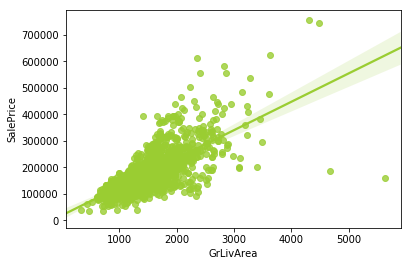

In [8]:
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=True, color = 'yellowgreen')
plt.show()

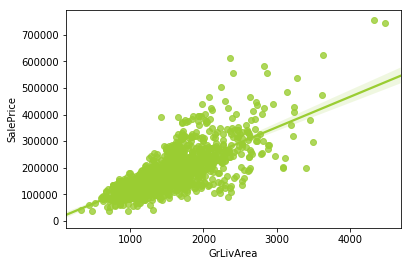

In [9]:
# Eliminando dos valores extremos extremos en la esquina inferior derecha
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Volvemos a ver el grafico
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=True, color = 'yellowgreen')
plt.show()

### Notas :
Eliminar todos los valores atípicos no es recomendable. Por lo tanto, solo decidimos borrar estos valores ya que son muy grandes y muy malos, ya que son áreas extremadamente grandes a precios muy bajos.
Existen otros valores atípicos en los datos de entrenamiento. Sin embargo, eliminar todos los outliers podría afectar el modelo, ya que si existiesen valores atípicos en el test no se va a predecir bien. Por lo tanto, para poder encontrar una solución razonable aun contando con los outliers usaremos modelos robustos para estos datos.

In [10]:
train.to_csv ('train_sin_outlaires.csv',sep=',')

### Variable Objetivo: SalesPrice 

In [11]:
train['SalePrice'].describe()

count     1458.000
mean    180932.919
std      79495.055
min      34900.000
25%     129925.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

Los cuartiles son los tres valores de la variable que dividen a un conjunto de datos ordenados en cuatro partes iguales. Q1, Q2 y Q3 determinan los valores correspondientes al 25%, al 50% y al 75% de los datos.
Como se puede apreciar en la siguiente imagen se puede apreciar los tres cuartiles, así como sus outilers, de los cuales se puede apreciar que hay 2 que son valores altamenten atípicos

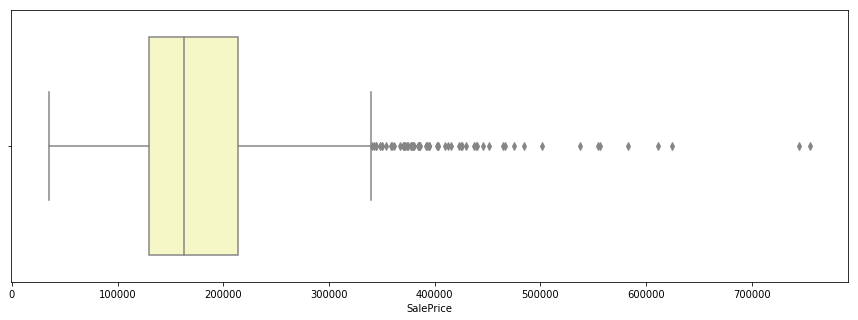

In [12]:
plt.figure(figsize = (15, 5))
sns.boxplot(train['SalePrice'], data = train, palette = 'RdYlGn')


Mu(media) = 180932.92 
Sigma(distribucion normal) = 79467.79



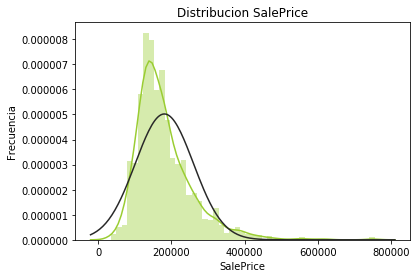

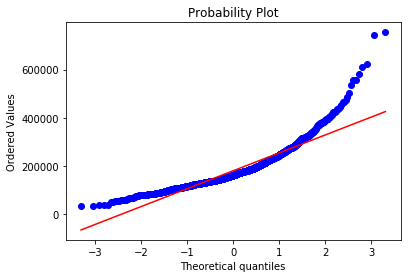

In [13]:
sns.distplot(train['SalePrice'] , fit=norm, color = "yellowgreen");

#Obtenemos los valores de mu y sigma para la funcion
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\nMu(media) = {:.2f} \nSigma(distribucion normal) = {:.2f}\n'.format(mu, sigma))

plt.ylabel('Frecuencia')
plt.title('Distribucion SalePrice')

#Obtenemos los QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Un gráfico Q-Q permite observar cuan cerca está la distribución de un conjunto de datos a alguna distribución ideal ó comparar la distribución de dos conjuntos de datos. 

Skewness: 1.881296


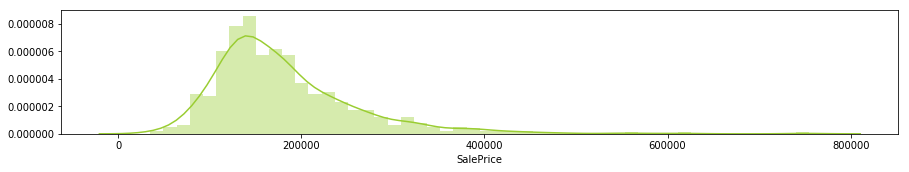

In [14]:
#Graficando la distribución de la variable SalePrice
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
_ = sns.distplot(train['SalePrice'], hist=True, kde=True, bins=50, color ="yellowgreen")

print('Skewness: %f' %  train['SalePrice'].skew())


Kurtosis: 6.523067


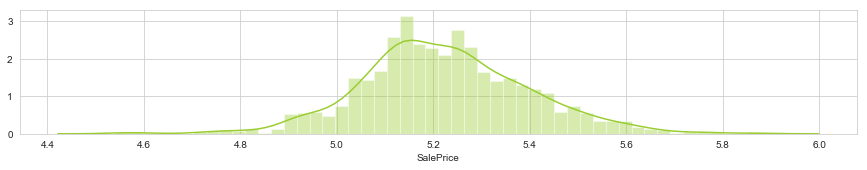

In [15]:
#Graficando la distribución de la variable SalePrice
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
ax2 = fig.add_subplot(212)
_ = sns.distplot(np.log10(train['SalePrice']), hist=True, kde=True, bins=50, color = "yellowgreen")
print('Kurtosis: %f' %  train['SalePrice'].kurtosis())

Skew: Con este valor podemos saber si los datos estan repartidos de forma simetrica, si dicho valor es cercano a 0 la variable es simetrica, en este caso podemos observar que efectivamente la variable SalePrice no es simetrica ya que obtiene un valor de 1.8.

Kurtosis: Este valor representa el grado de concentración que presentan los valores de una variable alrededor de una zona central, en este caso podemos observar que este valor al ser positivo se encuentra por encima de la distribucion normal.

La variable de destino está sesgada a la derecha. Como los modelos (lineales) aman los datos normalmente distribuidos, necesitamos transformar esta variable y hacerla más normalmente distribuida.

### Log-transformación de la variable de destino


Mu(media) = 12.02 
Sigma(distribucion normal) = 0.40



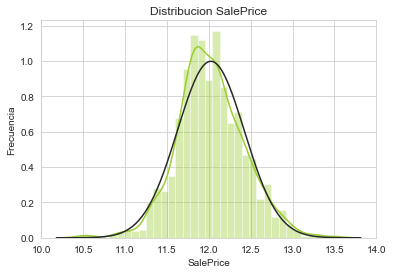

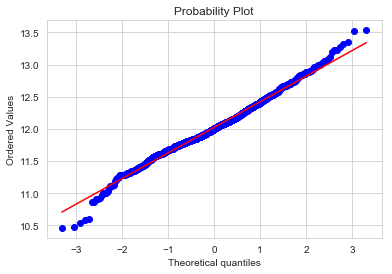

In [16]:
#Utilizamos la función numpy log1p que aplica log (1 + x) a todos los elementos de la columna
train["SalePrice"] = np.log1p(train["SalePrice"])

#Comprobamos la nueva distribucion
sns.distplot(train['SalePrice'] , fit=norm, color = "yellowgreen");

#Obtenemos los valores de mu y sigma para la funcion
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\nMu(media) = {:.2f} \nSigma(distribucion normal) = {:.2f}\n'.format(mu, sigma))

plt.ylabel('Frecuencia')
plt.title('Distribucion SalePrice')

#Obtenemos los QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Skewness: 0.121580


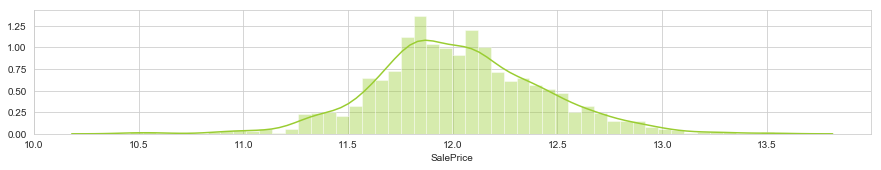

In [17]:
#Graficando la distribución de la variable SalePrice
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
_ = sns.distplot(train['SalePrice'], hist=True, kde=True, bins=50, color = "yellowgreen")

print('Skewness: %f' %  train['SalePrice'].skew())

Kurtosis: 0.804751


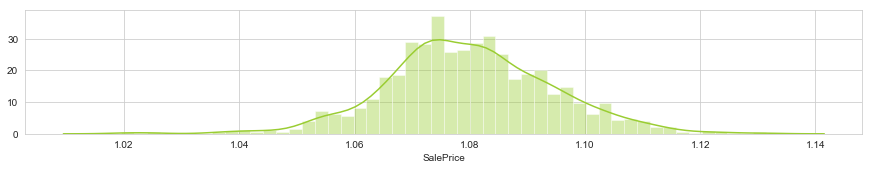

In [18]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
ax2 = fig.add_subplot(212)
_ = sns.distplot(np.log10(train['SalePrice']), hist=True, kde=True, bins=50, color = "yellowgreen")
print('Kurtosis: %f' %  train['SalePrice'].kurtosis())

Skew: Con este valor podemos saber si los datos están repartidos de forma simétrica, si dicho valor es cercano a 0 la variable es simétrica, en este caso podemos observar que efectivamente la variable SalePrice es simétrica ya que obtiene un valor de -0.008.

Kurtosis: Este valor representa el grado de concentración que presentan los valores de una variable alrededor de una zona central, en este caso podemos observar que este valor al ser positivo se encuentra por encima de la distribución normal.

De esta manera se puede apreciar que la variable destino ahora está normalmente distribuido.

### Carácteristicas

Primero vamos a concatenar los datos de entrenamiento y los datos de test en el mismo dataframa, esto nos servirá para el análisis de datos perdidos o incompletos más adelante.

In [19]:
#Guardamos las nuevas bases de datos "train" y "test"
ntrain = train.shape[0]
ntest = test.shape[0]

#Creamos la variable y_train
y_train = train.SalePrice.values

#Creamos la nueva base de datos que lleva tanto la informacion de train y test
all_data = pd.concat((train, test)).reset_index(drop=True)

#Descartamos la variable SalePrice que no está dentro del analisis
all_data.drop(['SalePrice'], axis=1, inplace=True)

### Datos Perdidos

Como fue evidente al inspeccionar inicialmente los datos, hay numerosos valores faltantes en todas las características. Para tener una mejor idea de esto, se creará una tabla para clasificar los valores perdidos basándonos en el porcentaje de datos faltantes.

In [20]:
missing_data = (all_data.isnull().sum() / len(all_data)) * 100
missing_data = missing_data.drop(missing_data[missing_data == 0].index).sort_values(ascending=False)[:30]
missing_aux = pd.DataFrame({'Ratio de Perdida' :missing_data})
missing_aux.head(20)

,Ratio de Perdida
PoolQC,99.691
MiscFeature,96.399
Alley,93.210
Fence,80.418
FireplaceQu,48.697
LotFrontage,16.667
GarageQual,5.453
GarageCond,5.453
GarageFinish,5.453
GarageYrBlt,5.453


Text(0.5, 1.0, 'Porcentaje de perdida por característica')

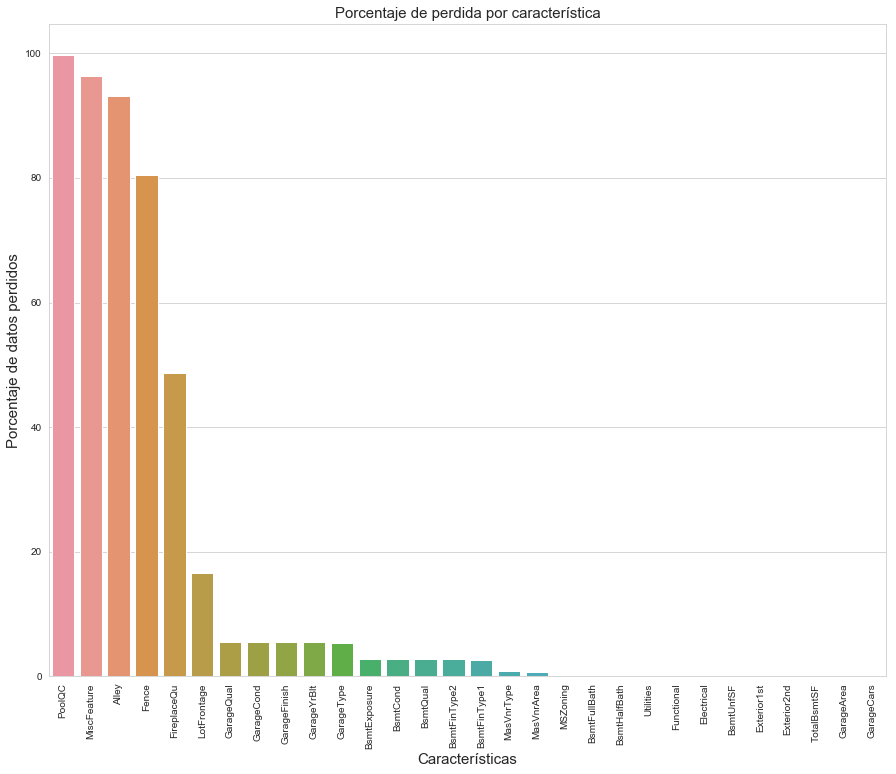

In [21]:
#Ahora aclaremos estos datos trazándolos en un gráfico:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data)
plt.xlabel('Características', fontsize=15)
plt.ylabel('Porcentaje de datos perdidos', fontsize=15)
plt.title('Porcentaje de perdida por característica', fontsize=15)

### Correlacion de Datos

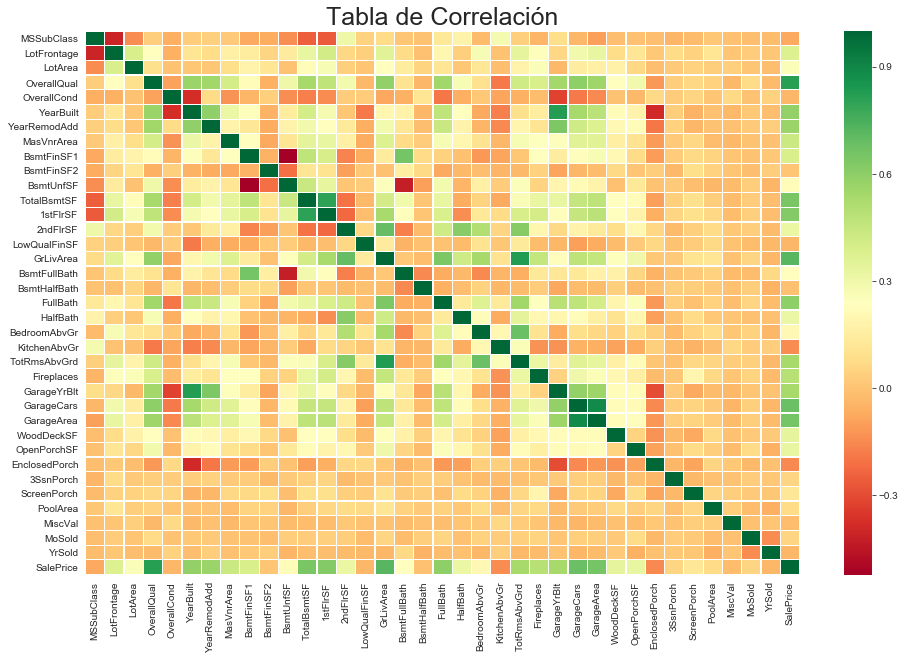

In [22]:
#La correlación constituye una técnica estadística que nos indica si dos variables están relacionadas o no.
corr = train.corr()
plt.figure(figsize=(16, 10))
plt.title('Tabla de Correlación', fontsize=25)
sns.heatmap(corr, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

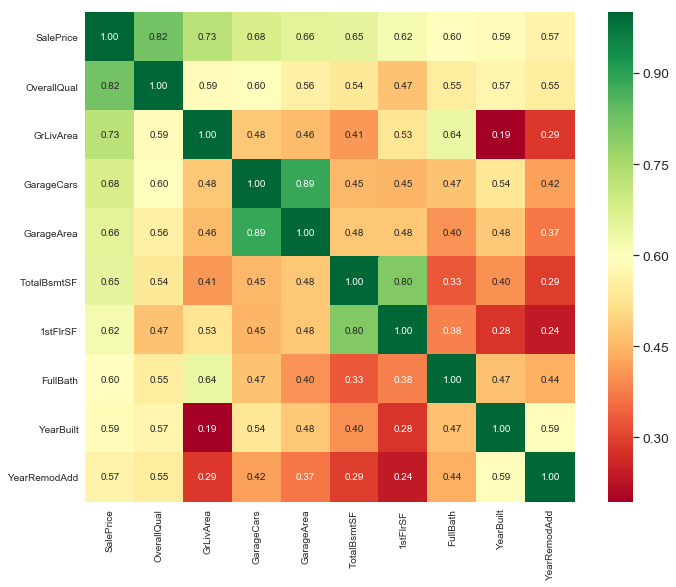

In [23]:
#Ahora solo mostraremos las 10 caracteristicas mas correlacionadas
#con relacion a SalePrice
cols = corr.nlargest(10, 'SalePrice')['SalePrice'].index
plt.subplots(figsize=(12,9))
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                 xticklabels=cols.values, cmap = 'RdYlGn', linecolor = 'white')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

Vamos a ver rápidamente las relaciones entre las variables

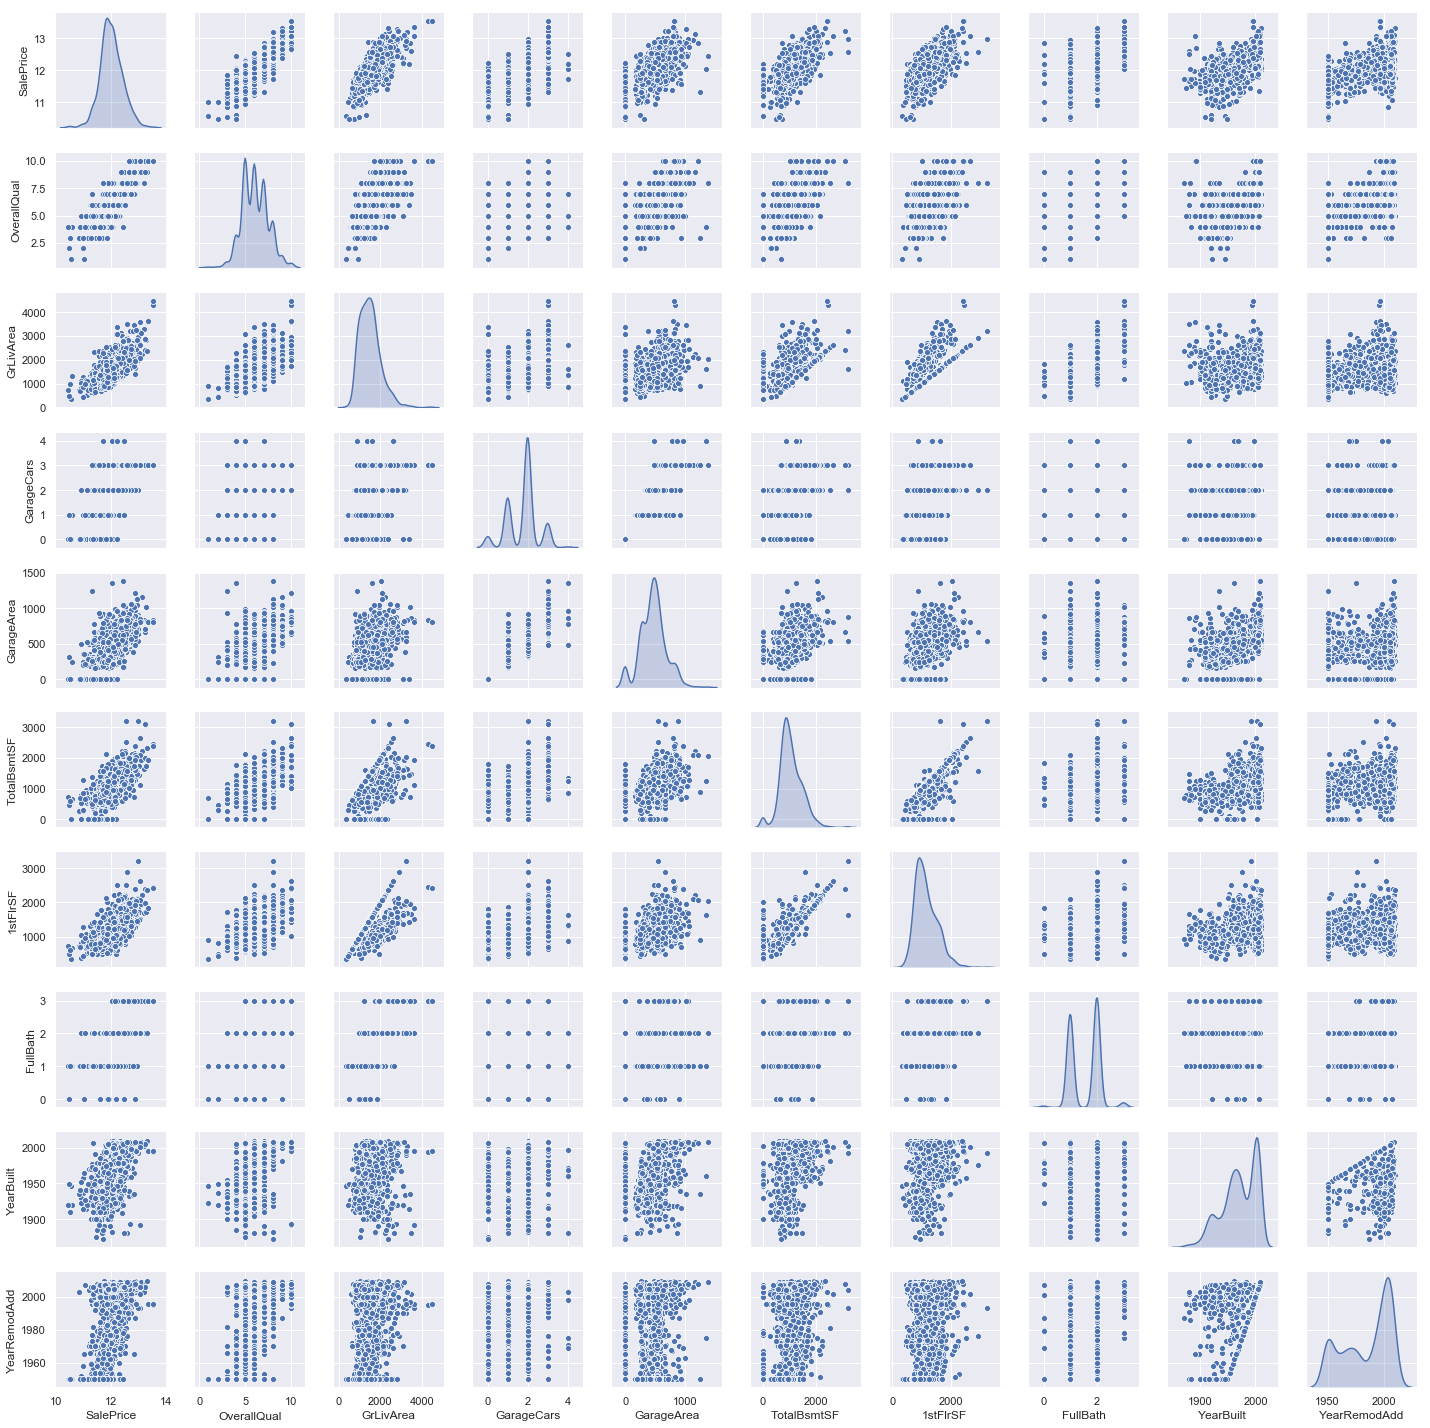

In [24]:
sns.set()
columns = ['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','YearBuilt','YearRemodAdd']
sns.pairplot(train[columns],size = 2 ,kind ='scatter',diag_kind='kde',palette='RdYlGn')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


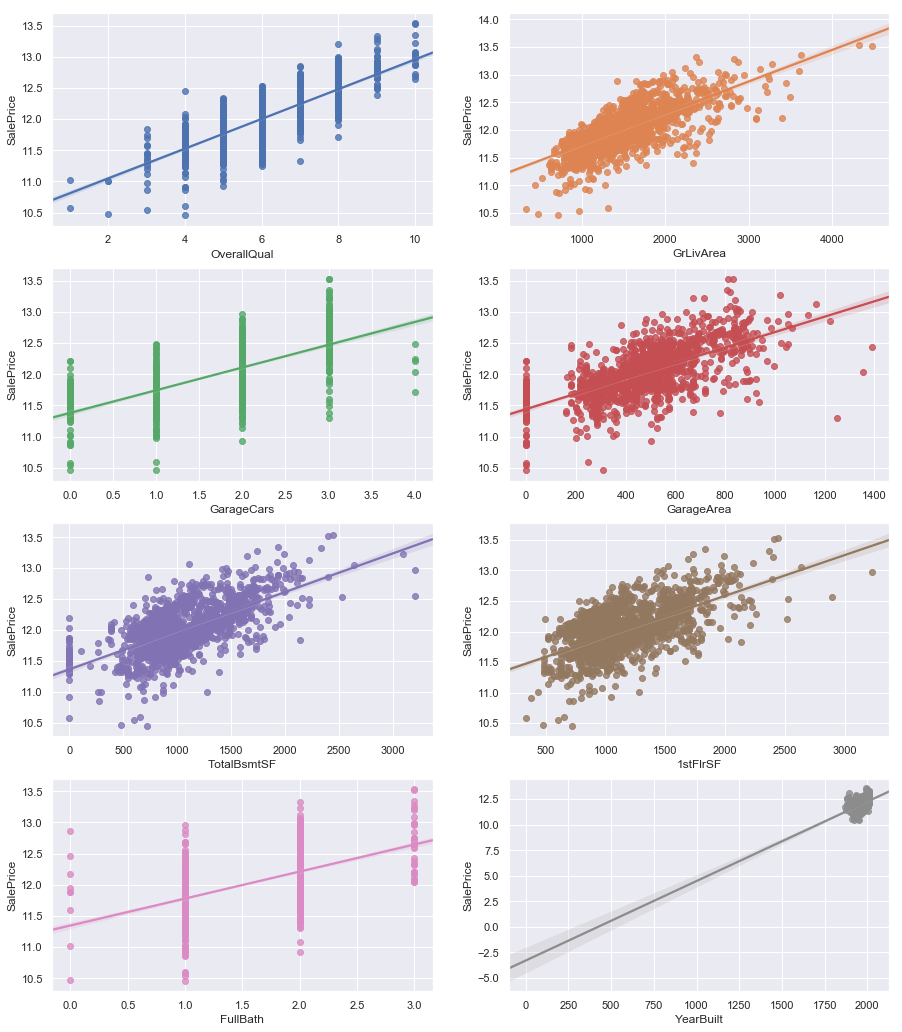

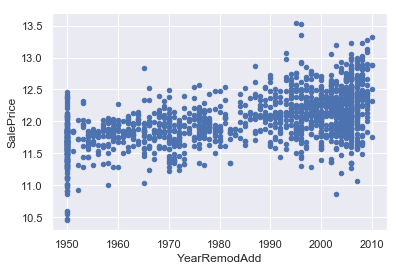

In [25]:
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6),(ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(15,18))

OverallQual_scatter_plot = pd.concat([train['SalePrice'],train['OverallQual']],axis = 1)
sns.regplot(x='OverallQual',y = 'SalePrice',data = OverallQual_scatter_plot,scatter= True, fit_reg=True, ax=ax1)

GrLivArea_scatter_plot = pd.concat([train['SalePrice'],train['GrLivArea']],axis = 1)
sns.regplot(x='GrLivArea',y = 'SalePrice',data = GrLivArea_scatter_plot,scatter= True, fit_reg=True, ax=ax2)

GarageCars_scatter_plot = pd.concat([train['SalePrice'],train['GarageCars']],axis = 1)
sns.regplot(x='GarageCars',y = 'SalePrice',data = GarageCars_scatter_plot,scatter= True, fit_reg=True, ax=ax3)

GarageArea_scatter_plot = pd.concat([train['SalePrice'],train['GarageArea']],axis = 1)
sns.regplot(x='GarageArea',y = 'SalePrice',data = GarageArea_scatter_plot,scatter= True, fit_reg=True, ax=ax4)

TotalBsmtSF_scatter_plot = pd.concat([train['SalePrice'],train['TotalBsmtSF']],axis = 1)
sns.regplot(x='TotalBsmtSF',y = 'SalePrice',data = TotalBsmtSF_scatter_plot,scatter= True, fit_reg=True, ax=ax5)

FirsttFlrSF_scatter_plot = pd.concat([train['SalePrice'],train['1stFlrSF']],axis = 1)
sns.regplot(x='1stFlrSF',y = 'SalePrice',data = FirsttFlrSF_scatter_plot,scatter= True, fit_reg=True, ax=ax6)

FullBath_scatter_plot = pd.concat([train['SalePrice'],train['FullBath']],axis = 1)
sns.regplot(x='FullBath',y = 'SalePrice',data = FullBath_scatter_plot,scatter= True, fit_reg=True, ax=ax7)

YearBuilt_scatter_plot = pd.concat([train['SalePrice'],train['YearBuilt']],axis = 1)
sns.regplot(x='YearBuilt',y = 'SalePrice',data = YearBuilt_scatter_plot,scatter= True, fit_reg=True, ax=ax8)

YearRemodAdd_scatter_plot = pd.concat([train['SalePrice'],train['YearRemodAdd']],axis = 1)
YearRemodAdd_scatter_plot.plot.scatter('YearRemodAdd','SalePrice')

De estos graficos se puede observar que el precio de las casas va aumentado en relacion a los años de construccion, por lo tanto si la casa es moderna valdrá más 

### Compeltar los datos perdidos

Se agruparan funciones en unas pocas operaciones diferentes según lo que mejor se adapte a su estructura:
 - Se puede reemplazar con una cadena
 - Se puede reemplazar con un entero
 - Se puede reemplazar con un cero
 - Se puede reemplazar con un valor especifico

In [26]:
# Se reemplazan los valores perdidos con None
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 
            'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

In [27]:
# Se reemplazan los valores perdidos con 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

LotFrontage: Ya que el área de cada calle conectada a la propiedad de la casa probablemente tenga un área similar a otras casas en su vecindario, podemos completar los valores faltantes con la mediana LotFrontage del vecindario.

In [28]:
# Se reemplazan los valores con el valor de la media
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [29]:
# Se reemplazan los valores perdidos con la moda
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [30]:
#functional: NA is typical
all_data["Functional"] = all_data["Functional"].fillna('Typ')

In [31]:
#dropping as same value 'AllPub' for all records except 2NA and 1 'NoSeWa'
#all_data = all_data.drop(['Utilities'], axis=1)

In [32]:
# Observamos de nuevo los valores perdidos:
all_data_missing = (all_data.isnull().sum() / len(all_data)) * 100
all_data_missing = all_data_missing.drop(all_data_missing[all_data_missing == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':all_data_missing})
missing_data.head(30)

,Missing Ratio
Utilities,0.069


In [33]:
# Convertimos aquellas variables que deberían ser categóricas, en lugar de numéricas
for col in ('MSSubClass', 'OverallCond', 'YrSold', 'MoSold'):
    all_data[col] = all_data[col].astype(str)

Dado que las características relacionadas con el área son muy importantes para determinar los precios de las casas, agregamos una característica más que es el área total del sótano, las áreas del primer y segundo piso de cada casa.

In [34]:
#Añadimos una nueva variable TotalSf = basement + firstflr + secondflr
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

Por último, haremos un analisis para encontrar cualquier desequilibrio de clase significativo. Cualquier variable que esté representada por una sola clase en más del 97% se eliminará de los conjuntos de datos. 

In [35]:
only_class = [col for col in all_data.select_dtypes(exclude=['number']) if 1 - sum(all_data[col] == mode(all_data[col]))/len(all_data) < 0.03]
only_class

['Condition2', 'Heating', 'PoolQC', 'RoofMatl', 'Street', 'Utilities']

In [36]:
# Borramos las caracteristicas encontradas
all_data = all_data.drop(['Condition2', 'Heating', 'PoolQC', 'RoofMatl', 'Street', 'Utilities'], axis=1)

In [37]:
train = all_data[:ntrain]
test = all_data[ntrain:]
train.to_csv ('train_sin_dummies.csv',sep=',')
test.to_csv ('test_sin_dummies.csv',sep=',')

### Añadir características categóricas ficticias

In [38]:
all_data = pd.get_dummies(all_data)

### Obtener los nuevos conjuntos de train y test.

In [39]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [40]:
train.to_csv ('train_dummies.csv',sep=',')
test.to_csv ('test_dummies.csv',sep=',')

# Modelo

### Definimos la validacion cruzada
Usamos la función cross_val_score de Sklearn. Sin embargo, esta función no tiene un atributo aleatorio, agregamos entonces una línea de código, para barajar el conjunto de datos antes de la validación cruzada

In [41]:
X_train = train
X_test = test

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

### LASSO Regression :
Este modelo puede ser muy sensible a los valores atípicos. Así que tenemos que hacerlo más robusto en ellos. Para eso usamos el método de sklearn's Robustscaler () en las tuberias

In [42]:
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

### Elastic Net Regression :

In [43]:
model_elastic = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

### Gradient Boosting Regression :

In [44]:
model_gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

### XGBoost :

In [45]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

# Apilamos los modelos
El apilamiento puede ser beneficioso, ya que la combinación de modelos permite que se combinen los mejores elementos de su poder predictivo, por lo que se suavizan los huecos que quedan de un modelo individual y aumenta la probabilidad de un rendimiento general más sólido del modelo.

In [46]:
# Fit and predict all models
model_lasso.fit(X_train, y_train)
rmse_lasso = rmse_cv(model_lasso).mean()

model_elastic.fit(X_train, y_train)
rmse_elastic = rmse_cv(model_elastic).mean()

model_gbr.fit(X_train, y_train)
rmse_gbr = rmse_cv(model_gbr).mean()

model_xgb.fit(X_train, y_train)
rmse_xgb = rmse_cv(model_xgb).mean()

In [47]:
resultados_rmse_cv = pd.DataFrame({
    'Model': ['Lasso',
              'ElasticNet',
              'Gradient Boosting Regressor',
              'XGBoost Regressor'],
    'Score': [rmse_lasso,
              rmse_elastic,
              rmse_gbr,
              rmse_xgb]})

# Build dataframe of values
result_aux = resultados_rmse_cv.sort_values(by='Score', ascending=True).reset_index()
result_aux.head()

,index,Model,Score
0,1,ElasticNet,0.110
1,0,Lasso,0.110
2,2,Gradient Boosting Regressor,0.115
3,3,XGBoost Regressor,0.116


In [48]:
#Predicciones de cada modelo
lasso_pred = np.expm1(model_lasso.predict(X_test))
elastic_pred = np.expm1(model_elastic.predict(X_test))
gbr_pred = np.expm1(model_gbr.predict(X_test))
xgb_pred = np.expm1(model_xgb.predict(X_test))

# Prediccion Final

In [49]:
stacked = (lasso_pred + elastic_pred +  xgb_pred + gbr_pred) / 4

In [50]:
final = pd.DataFrame()
final['Id'] = test_ID
final['SalePrice-Prediccion'] = stacked
final.to_csv('Prediccion_Final.csv',index=False)
final.head()

,Id,SalePrice-Prediccion
0,1461,121916.595
1,1462,158574.798
2,1463,183269.633
3,1464,201321.151
4,1465,189610.249
